# LSTM预测股票走势

## 股票走势预测实验介绍

### 1.1 实验目的

1. 了解时间序列数据并理解时间序列数据预处理技术
2. 理解经典时序模型LSTM(长短期记忆网络)的基础知识
3. 通过搭建LSTM模型，实现股票走势的预测
4. 了解AI技术在不同行业中的应用

### 1.2 实验内容

本实验任务根据一只股票的价格走势，构建一个LSTM网络预测其未来的涨跌情况。

### 1.3 实验环境

本地：常用的tensorflow、keras、numpy等

### 1.4 LSTM模型

LSTM由重复模块链形成，每个单个模块称为细胞（元胞）。各元胞都有特定的门结构来实现选择性让信息传递，通过LSTM门结构（遗忘门、输入门、细胞状态更新、输出门）信息的传递，实现各个元胞状态的更新。元胞的结构如图。其中为Sigmoid激活函数，表示基本积运算(Hadamard)，tanh表示tanh激活函数。

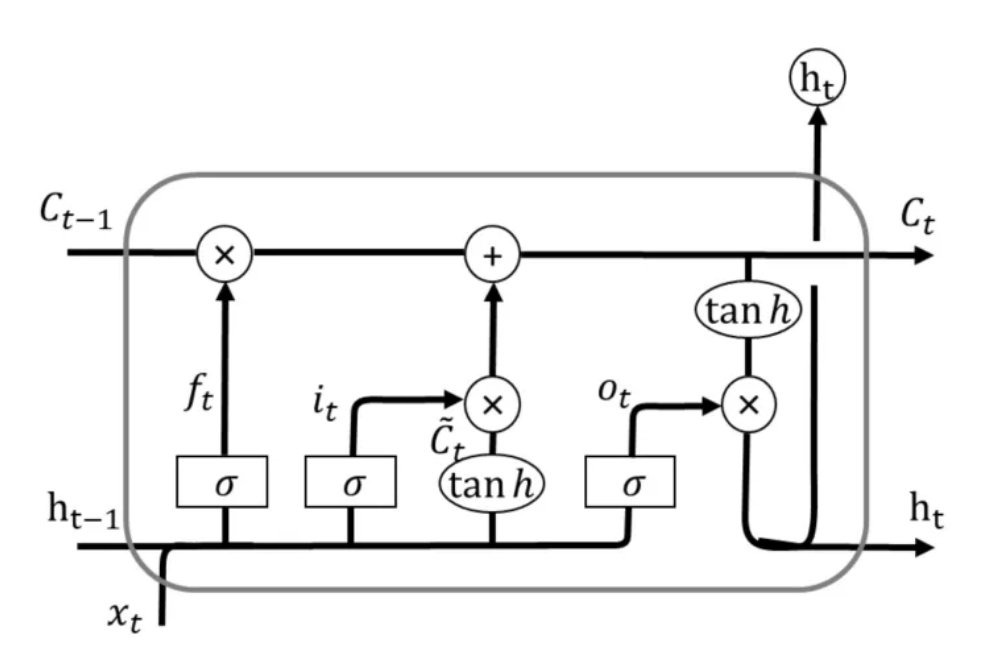

遗忘门的作用是选择性的更新细胞状态。LSTM的第一步是确定元胞状态的更新。它通过Sigmoid函数对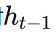(前一个输出)和
(当前输入)处理，输出0-1之间的数字。1代表完全保留，而0代表完全遗忘。其中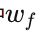为权重矩阵，为偏置项。

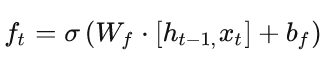

输入门的作用是输入数据，决定细胞状态中储存的信息。这一部分分为两步，首先是由Sigmoid层确定输入信息在更新中所占的权重，即哪些信息需要更新。接下来通过tanh构建由此时计算形成候选向量。


# 2. 实验任务实现

基于LSTM股票涨跌情况预测流程主要包含以下步骤：

1. 数据处理：根据预测的目标，进行数据预处理操作，完成数据集的构建；
2. 模型构建：设计时间序列预测模型，判断股票涨跌情况
3. 训练配置：实例化模型，选择模型计算资源，指定优化算法；
4. 训练与评估：执行多轮训练调整参数，以达到最优效果，并对训练好的模型进行评估测试，观察准确率和Loss；
5. 模型推理：选取一条数据，通过模型推理出涨跌情况。

## 2.1 数据处理

### 2.1.1数据读取

Tushare是一个免费、开源的python财经数据接口包。主要实现对股票等金融数据从数据采集、清洗加工到数据存储的过程，能够为金融分析人员提供快速、整洁、和多样的便于分析的数据，为他们在数据获取方面极大地减轻工作量，使他们更加专注于策略和模型的研究与实现上。Tushare返回的绝大部分的数据格式都是pandas DataFrame类型。
   +  import tushare as ts
   +  df = ts.get_hist_data('002648')  #获取股票数据
   +  df.to_csv("stock.csv")   #命名并保存至本地
          
#### 实验中A股票数据已通过Tushare读取，并保存在本地，供大家直接使用。

#### 在获取的历史A股K线数据中，各参数名称含义如下：

+ date：日期
+ open：开盘价
+ high：最高价
+ close：收盘价
+ low：最低价
+ volume：成交量
+ price_change：价格变动
+ p_change：涨跌幅
+ ma5：5日均价
+ ma10：10日均价
+ ma20:20日均价
+ v_ma5:5日均量
+ v_ma10:10日均量
+ v_ma20:20日均量

In [1]:
import pandas as pd

df = pd.read_csv('stock.csv') # 读取csv文件并转化为DataFrame
df.info() #打印DataFrame的简要摘要
df.columns  #查看数据中“列”名，有哪些字段，即数据有哪些特征
print(df.head())  #查看前5行数据样例
df['buy_flag'] = 10 #新增一列，表示涨跌情况，设初始认值为10
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          605 non-null    object 
 1   open          605 non-null    float64
 2   high          605 non-null    float64
 3   close         605 non-null    float64
 4   low           605 non-null    float64
 5   volume        605 non-null    float64
 6   price_change  605 non-null    float64
 7   p_change      605 non-null    float64
 8   ma5           605 non-null    float64
 9   ma10          605 non-null    float64
 10  ma20          605 non-null    float64
 11  v_ma5         605 non-null    float64
 12  v_ma10        605 non-null    float64
 13  v_ma20        605 non-null    float64
 14  turnover      605 non-null    float64
dtypes: float64(14), object(1)
memory usage: 71.0+ KB
         date   open   high  close    low     volume  price_change  p_change   
0  2023-05-22  13.13  13.42  1

### 2.1.2时间序列数据的展示

绘制股票K线图。

K线图（Candlestick Charts）又称蜡烛图，是一条柱状的线条，由影线和实体组成。影线在实体上方的部分叫上影线,下方的部分叫下影线。实体分阳线和阴线。其中影线表明当天交易的最高和最低价，而实体表明当天的开盘价和收盘价。

In [2]:
df_plots = df[['date', 'open', 'high', 'low', 'close','volume']] #去掉多余数据，只保留作图需要的数据列
print(df_plots) #打印df_plots
df_plots = df_plots[::-1] #时间倒序改为正序
df_plots.set_index(["date"], inplace=True) #将date列数据设置为索引
print(df_plots) #观察df_plots变化
df_plots.index = pd.to_datetime(df_plots.index) #将date列数据转换成datetime类型
print(df_plots.index) #观察索引数据类型变化

           date   open   high    low  close     volume
0    2023-05-22  13.13  13.42  13.03  13.38  117211.14
1    2023-05-19  13.20  13.25  12.99  13.13  153192.66
2    2023-05-18  13.59  13.71  13.15  13.20  147922.58
3    2023-05-17  13.58  13.63  13.37  13.52  101815.08
4    2023-05-16  13.62  13.79  13.57  13.62  106893.07
..          ...    ...    ...    ...    ...        ...
600  2020-11-27  26.02  26.62  25.80  26.60   91515.98
601  2020-11-26  26.37  26.39  25.36  26.03  100030.77
602  2020-11-25  27.99  28.10  26.05  26.13  193465.14
603  2020-11-24  27.15  27.53  26.60  27.48   79870.72
604  2020-11-23  26.27  27.77  26.03  27.12  146350.16

[605 rows x 6 columns]
             open   high    low  close     volume
date                                             
2020-11-23  26.27  27.77  26.03  27.12  146350.16
2020-11-24  27.15  27.53  26.60  27.48   79870.72
2020-11-25  27.99  28.10  26.05  26.13  193465.14
2020-11-26  26.37  26.39  25.36  26.03  100030.77
2020-11-27  26.0

In [3]:
!pip install mpl-finance
!pip install --upgrade mplfinance

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


c:\Users\73915\.conda\envs\py38\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


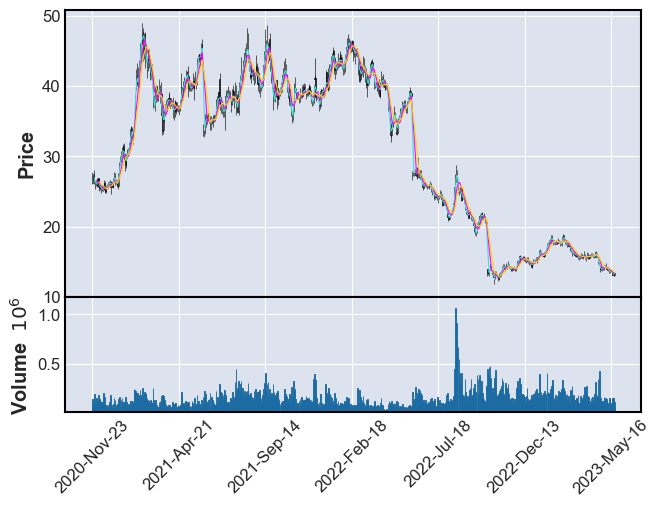

In [4]:
from matplotlib import pyplot as plt
import mplfinance as mpf   #Mplfinance是由matplotlib 开发团队开发的专门用于金融数据可视化分析。需要安装：pip install mpl-finance
mpf.plot(df_plots, type='candle', mav=(3,6,9), volume=True) #绘制k线图，并添加3日均线、6日均线和9日均线

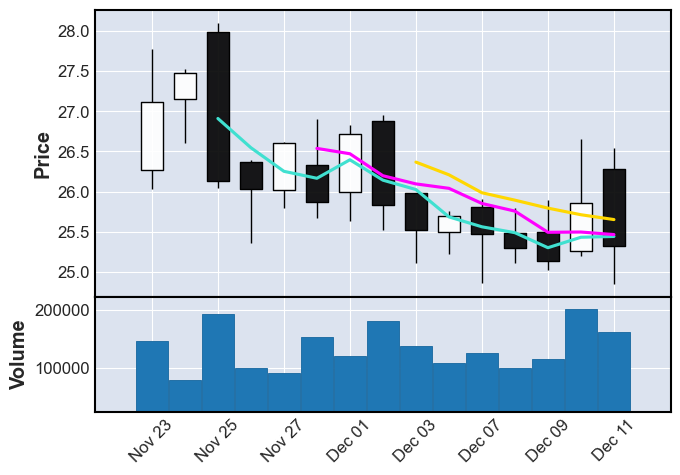

In [5]:
mpf.plot(df_plots[0:15], type='candle',mav=(3,6,9), volume=True)  #为了看得更清楚，可以选取少量数据绘图

### 2.1.3数据集的处理

因为股票价格的波动非常不可控，所以退而求其次，预测股票的走势，即涨还是跌。

但是怎么量化股票的涨跌是个问题，本实验用未来数天的平均股价表示股票的起伏。

假设短期2天，中期6天，长期15天。如果未来15天平均价格大于未来6天平均价格大于未来2天平均价格，就可认为未来15天的股市走势很好。这里还要求有3%的涨幅，能一定程度上减少标签频繁波动。

2 含义为买入，0 含义为卖出，1 为默认值

In [6]:
#未来n天移动平均，包含今天
def MA_next(df, date_idx, price_type, n): 
    return df[price_type][date_idx:date_idx+n].mean()

df.head()

,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover,buy_flag
0,2023-05-22,13.13,13.42,13.38,13.03,117211.14,0.25,1.90,13.370,13.593,13.928,125406.91,124925.04,156892.77,0.35,10
1,2023-05-19,13.20,13.25,13.13,12.99,153192.66,-0.07,-0.53,13.416,13.678,14.049,128859.18,128078.54,160419.30,0.46,10
2,2023-05-18,13.59,13.71,13.20,13.15,147922.58,-0.32,-2.37,13.492,13.818,14.209,128159.01,125703.65,160413.47,0.44,10
3,2023-05-17,13.58,13.63,13.52,13.37,101815.08,-0.10,-0.73,13.646,13.939,14.368,117927.56,126945.87,168867.84,0.30,10
4,2023-05-16,13.62,13.79,13.62,13.57,106893.07,0.01,0.07,13.734,14.006,14.478,117872.84,129021.70,173482.78,0.32,10


In [7]:
s_time = 2
m_time = 6
l_time = 15

for i in range(len(df)-l_time):
    if MA_next(df, i, 'close', l_time)> MA_next(df,i,'close', m_time)*1.03 > MA_next(df,i,'close', s_time)*1.03:
        df.loc[i, 'buy_flag'] = 2
    elif MA_next(df, i, 'close', s_time) > MA_next(df, i, 'close', m_time):
        df.loc[i, 'buy_flag'] = 0
    else:
        df.loc[i, 'buy_flag'] = 1

print(df.head())
print("======")
print("before dele", df.shape)
df = df[df.buy_flag != 10]
print("after dele", df.shape)

         date   open   high  close    low     volume  price_change  p_change   
0  2023-05-22  13.13  13.42  13.38  13.03  117211.14          0.25      1.90  \
1  2023-05-19  13.20  13.25  13.13  12.99  153192.66         -0.07     -0.53   
2  2023-05-18  13.59  13.71  13.20  13.15  147922.58         -0.32     -2.37   
3  2023-05-17  13.58  13.63  13.52  13.37  101815.08         -0.10     -0.73   
4  2023-05-16  13.62  13.79  13.62  13.57  106893.07          0.01      0.07   

      ma5    ma10    ma20      v_ma5     v_ma10     v_ma20  turnover  buy_flag  
0  13.370  13.593  13.928  125406.91  124925.04  156892.77      0.35         2  
1  13.416  13.678  14.049  128859.18  128078.54  160419.30      0.46         2  
2  13.492  13.818  14.209  128159.01  125703.65  160413.47      0.44         1  
3  13.646  13.939  14.368  117927.56  126945.87  168867.84      0.30         1  
4  13.734  14.006  14.478  117872.84  129021.70  173482.78      0.32         1  
before dele (605, 16)
after dele 

In [8]:
print(df.columns)
print(df.head())
print(df.tail())

Index(['date', 'open', 'high', 'close', 'low', 'volume', 'price_change',
       'p_change', 'ma5', 'ma10', 'ma20', 'v_ma5', 'v_ma10', 'v_ma20',
       'turnover', 'buy_flag'],
      dtype='object')
         date   open   high  close    low     volume  price_change  p_change   
0  2023-05-22  13.13  13.42  13.38  13.03  117211.14          0.25      1.90  \
1  2023-05-19  13.20  13.25  13.13  12.99  153192.66         -0.07     -0.53   
2  2023-05-18  13.59  13.71  13.20  13.15  147922.58         -0.32     -2.37   
3  2023-05-17  13.58  13.63  13.52  13.37  101815.08         -0.10     -0.73   
4  2023-05-16  13.62  13.79  13.62  13.57  106893.07          0.01      0.07   

      ma5    ma10    ma20      v_ma5     v_ma10     v_ma20  turnover  buy_flag  
0  13.370  13.593  13.928  125406.91  124925.04  156892.77      0.35         2  
1  13.416  13.678  14.049  128859.18  128078.54  160419.30      0.46         2  
2  13.492  13.818  14.209  128159.01  125703.65  160413.47      0.44         1

### 2.1.4构造训练集与验证集

接下来将数据生成时间序列，用前seq_length天的信息作为输入序列，后1天的股市起伏buy_flag作为标签



In [9]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

seq_length = 30
df = df[::-1]
print("before:", df)

df.set_index(["date"], inplace=True)


print("after:",df)
x_scaler = MinMaxScaler()

X = df.drop(['buy_flag'], axis=1).values
X = x_scaler.fit_transform(X)

# print(X[0])
Y = df['buy_flag']
Y = np.array(Y).reshape(-1,1)
# print(Y)
# print(X.shape)
# print(Y.shape)

x = []
y = []
for i in range(len(X)-seq_length):
    _x = X[i:(i+seq_length)]
    _y = Y[i+seq_length]
    x.append(_x)
    y.append(_y)
    
X = np.array(x)
Y = np.array(y)
# print(X.shape)
# print(Y.shape)

before:            date   open   high  close    low     volume  price_change   
589  2020-12-14  25.24  25.82  25.10  24.87   78088.71         -0.23  \
588  2020-12-15  25.05  25.82  25.76  24.75   77624.38          0.66   
587  2020-12-16  25.66  26.10  25.62  25.54   55022.21         -0.14   
586  2020-12-17  25.74  26.36  26.03  25.50   81555.84          0.41   
585  2020-12-18  26.06  26.54  26.19  25.73   94225.73          0.16   
..          ...    ...    ...    ...    ...        ...           ...   
4    2023-05-16  13.62  13.79  13.62  13.57  106893.07          0.01   
3    2023-05-17  13.58  13.63  13.52  13.37  101815.08         -0.10   
2    2023-05-18  13.59  13.71  13.20  13.15  147922.58         -0.32   
1    2023-05-19  13.20  13.25  13.13  12.99  153192.66         -0.07   
0    2023-05-22  13.13  13.42  13.38  13.03  117211.14          0.25   

     p_change     ma5    ma10    ma20      v_ma5     v_ma10     v_ma20   
589     -0.91  25.346  25.598  25.951  131512.71  133

In [10]:
# 划分训练集和测试集
x_train, x_test = X[:int(X.shape[0]*0.8)], X[int(X.shape[0]*0.8):]  
y_train, y_test = Y[:int(Y.shape[0]*0.8)], Y[int(Y.shape[0]*0.8):]
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

## 2.2 模型搭建

构建一层LSTM提取时间序列特征，再输入全连接层进行分类，预测涨跌类别

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense

In [12]:
model = tf.keras.Sequential()
model.add(LSTM(128, activation='relu', return_sequences=False, input_shape=(None, 14)))
model.add(Dense(3, activation="softmax"))


## 2.3 模型配置

In [13]:
model.compile(metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam')


## 2.4 模型训练与评估

In [14]:
model.fit(x=x_train, y=y_train, epochs=50)
test_acc = model.evaluate(x_test, y_test)

Epoch 1/50
14/14 [==============================] - 5s 93ms/step - loss: 1.0076 - accuracy: 0.4955
Epoch 2/50
14/14 [==============================] - 1s 49ms/step - loss: 0.9819 - accuracy: 0.4955
Epoch 3/50
14/14 [==============================] - 1s 52ms/step - loss: 0.9739 - accuracy: 0.4955
Epoch 4/50
14/14 [==============================] - 1s 49ms/step - loss: 0.9548 - accuracy: 0.5290
Epoch 5/50
14/14 [==============================] - 1s 51ms/step - loss: 0.9373 - accuracy: 0.5246
Epoch 6/50
14/14 [==============================] - 1s 70ms/step - loss: 0.9267 - accuracy: 0.5246
Epoch 7/50
14/14 [==============================] - 1s 54ms/step - loss: 0.9037 - accuracy: 0.5603
Epoch 8/50
14/14 [==============================] - 1s 52ms/step - loss: 0.9363 - accuracy: 0.5201
Epoch 9/50
14/14 [==============================] - 1s 66ms/step - loss: 0.9448 - accuracy: 0.5045
Epoch 10/50
14/14 [==============================] - 1s 66ms/step - loss: 0.9306 - accuracy: 0.5268
Epoch 11/

## 2.5 模型推理

In [15]:
print(x_test[0:1])
print(x_test[0:1].shape)
y_predict = model.predict(x_test[0:1])
print(y_predict)

[[[3.58731924e-02 2.42024202e-02 2.32945092e-02 3.60779750e-02
   1.64396390e-01 5.12643678e-01 3.99500000e-01 2.75218590e-02
   8.32695780e-02 1.54946250e-01 4.14958542e-01 4.86904484e-01
   6.49354527e-01 9.88235294e-02]
  [2.66963293e-02 2.33773377e-02 1.22018857e-02 2.82222869e-02
   2.15586321e-01 4.97701149e-01 3.48500000e-01 2.15949768e-02
   5.92771674e-02 1.45284105e-01 3.58862543e-01 5.12025748e-01
   6.63792122e-01 1.34117647e-01]
  [0.00000000e+00 0.00000000e+00 4.71436495e-03 0.00000000e+00
   3.17700996e-01 5.12643678e-01 3.94500000e-01 1.05040784e-02
   3.40912568e-02 1.33350397e-01 3.26686139e-01 5.62026100e-01
   6.60237324e-01 2.09411765e-01]
  [1.25139043e-02 3.05280528e-02 2.60676650e-02 2.26942101e-02
   3.91100623e-01 6.32183908e-01 8.06000000e-01 7.10052227e-03
   1.33733207e-02 1.21928590e-01 3.49074832e-01 5.93913008e-01
   6.73651821e-01 2.61176471e-01]
  [3.47608454e-02 2.94279428e-02 2.35718247e-02 3.72417806e-02
   1.40952010e-01 5.33333333e-01 4.65500000e-